In [24]:
import os
import math
import warnings
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.distributions as dist

from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.preprocessing import MinMaxScaler
from scipy import signal

from sklearn.model_selection import train_test_split
from tabulate import tabulate

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 'truetype'})
warnings.simplefilter("ignore")

print("PyTorch version " + torch.__version__)

#
# Helper functions
#
def minmax(x):
    return MinMaxScaler().fit_transform(np.atleast_2d(x).T).T[0]

PyTorch version 1.13.1+cu117


In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#change this five times to get 5 cross validation
SEED = 999
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda:0


## 1. ETL (Extract, Transform, Load)

In [116]:
df = pd.read_csv('datasets/selected_500user.csv')
df

,MeterID,DATE-Time,KWH
0,6200093839,2021-01-01 00:00:00,0.602
1,6200093839,2021-01-01 00:15:00,0.589
2,6200093839,2021-01-01 00:30:00,0.410
3,6200093839,2021-01-01 00:45:00,0.495
4,6200093839,2021-01-01 01:00:00,0.450
...,...,...,...
16967640,6200091271,2021-12-31 22:45:00,1.323
16967641,6200091271,2021-12-31 23:00:00,1.327
16967642,6200091271,2021-12-31 23:15:00,1.321
16967643,6200091271,2021-12-31 23:30:00,1.311


## 2. EDA (Exploratory Data Analysis)

In [117]:
df

,MeterID,DATE-Time,KWH
0,6200093839,2021-01-01 00:00:00,0.602
1,6200093839,2021-01-01 00:15:00,0.589
2,6200093839,2021-01-01 00:30:00,0.410
3,6200093839,2021-01-01 00:45:00,0.495
4,6200093839,2021-01-01 01:00:00,0.450
...,...,...,...
16967640,6200091271,2021-12-31 22:45:00,1.323
16967641,6200091271,2021-12-31 23:00:00,1.327
16967642,6200091271,2021-12-31 23:15:00,1.321
16967643,6200091271,2021-12-31 23:30:00,1.311


In [118]:
# # Data prepreration
# # Get unique MeterID values
# unique_meter_ids = df['MeterID'].unique()

# # Create a new list of user IDs as strings
# user_ids = [str(i) for i in range(len(unique_meter_ids))]

# # Create a dictionary that maps each unique MeterID value to a unique user ID
# user_id_dict = {meter_id: user_id for meter_id, user_id in zip(unique_meter_ids, user_ids)}

# # Create a new column "user" that maps each MeterID value to a user ID
# df["user"] = df["MeterID"].apply(lambda x: user_id_dict[x])

# # Select user_1 to explore
# user_1 = df[df['user']=='0']

# # Drop not useful columns
# user_1['DATE-Time'] = pd.to_datetime(user_1['DATE-Time'], infer_datetime_format=True)
# user_1.drop(columns=["MeterID", "user"], inplace=True)

# # Resample `15min` in order to have completed `"DATE-Time"`
# # I have `'DATE-Time'` 32760 rows (32760/96=341.25 Days)
# # It should be (365day * 96point = 35040 rows)
# # I have to reset index in order to hava 35040 rows
# # Fill the missing value
# user_1 = user_1.set_index('DATE-Time').resample("15T").mean()

# # Drop the days that have NaN values
# # Check which rows have at least one missing value
# missing_days = user_1.isnull().any(axis=1)

# # Get the dates (i.e., indices) of the rows that have missing values
# missing_days_index = missing_days[missing_days].index

# # Get the unique dates that have missing values
# missing_dates = pd.Series(missing_days_index.date).unique().tolist()

# # Drop the entire dates that contain Nan values
# user_1_clean = user_1[~user_1.index.to_series().dt.date.isin(missing_dates)]

In [119]:
def clean_data(df):
    # Get unique MeterID values
    unique_meter_ids = df['MeterID'].unique()

    # Create a new list of user IDs as strings
    user_ids = [str(i) for i in range(len(unique_meter_ids))]

    # Create a dictionary that maps each unique MeterID value to a unique user ID
    user_id_dict = {meter_id: user_id for meter_id, user_id in zip(unique_meter_ids, user_ids)}

    # Create a new column "user" that maps each MeterID value to a user ID
    df["user"] = df["MeterID"].apply(lambda x: user_id_dict[x])

    # Select user_1 to explore
    user_1 = df[df['user']=='0']

    # Drop not useful columns
    user_1['DATE-Time'] = pd.to_datetime(user_1['DATE-Time'], infer_datetime_format=True)
    user_1.drop(columns=["MeterID", "user"], inplace=True)

    # Resample `15min` in order to have completed `"DATE-Time"`
    # I have `'DATE-Time'` 32760 rows (32760/96=341.25 Days)
    # It should be (365day * 96point = 35040 rows)
    # I have to reset index in order to hava 35040 rows
    # Fill the missing value
    user_1 = user_1.set_index('DATE-Time').resample("15T").mean()

    # Drop the days that have NaN values
    # Check which rows have at least one missing value
    missing_days = user_1.isnull().any(axis=1)

    # Get the dates (i.e., indices) of the rows that have missing values
    missing_days_index = missing_days[missing_days].index

    # Get the unique dates that have missing values
    missing_dates = pd.Series(missing_days_index.date).unique().tolist()

    # Drop the entire dates that contain Nan values
    user_1_clean = user_1[~user_1.index.to_series().dt.date.isin(missing_dates)]
    
    return user_1_clean

In [120]:
user_1_clean = clean_data(df)
user_1_clean

,KWH
DATE-Time,
2021-01-01 00:00:00,0.602
2021-01-01 00:15:00,0.589
2021-01-01 00:30:00,0.410
2021-01-01 00:45:00,0.495
2021-01-01 01:00:00,0.450
...,...
2021-12-31 22:45:00,0.405
2021-12-31 23:00:00,0.349
2021-12-31 23:15:00,0.305


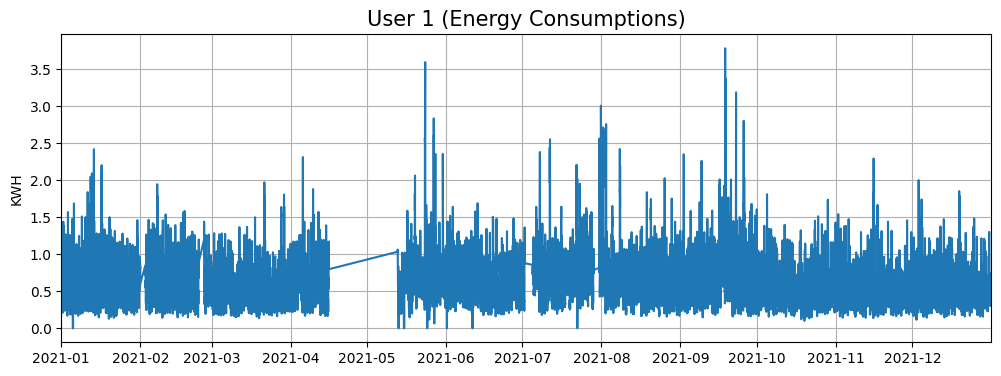

In [123]:
plt.figure(figsize=(12,4))
plt.title('User 1 (Energy Consumptions)', size=15)
plt.ylabel('KWH')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(user_1_clean['KWH'])
plt.show()

## 3. Prepare the data

In [124]:
import numpy as np

def create_windowed_dataset(data, window_size):
    # Calculate the number of windows that fit in the data
    num_windows = len(data) // window_size
    
    # Truncate data to fit into windowed data exactly
    data = data[:num_windows*window_size]
    
    # Reshape the data into a 3D tensor of (num_windows, window_size, num_features)
    windowed_data = np.reshape(data, (num_windows, window_size, 1))
    
    return windowed_data

# Example usage
window_size = 96
data = user_1_clean.to_numpy()
windowed_data = create_windowed_dataset(data, window_size)
print(windowed_data.shape)

(329, 96, 1)


The shape of the dataset is `(329, 96, 1)` which means: 
* we have `329` samples `(i.e., 329 non-overlapping windows)`,
* each window has `96` time steps `(i.e., 96 data points)`,
* and `1` feature `(i.e., KWH)`.

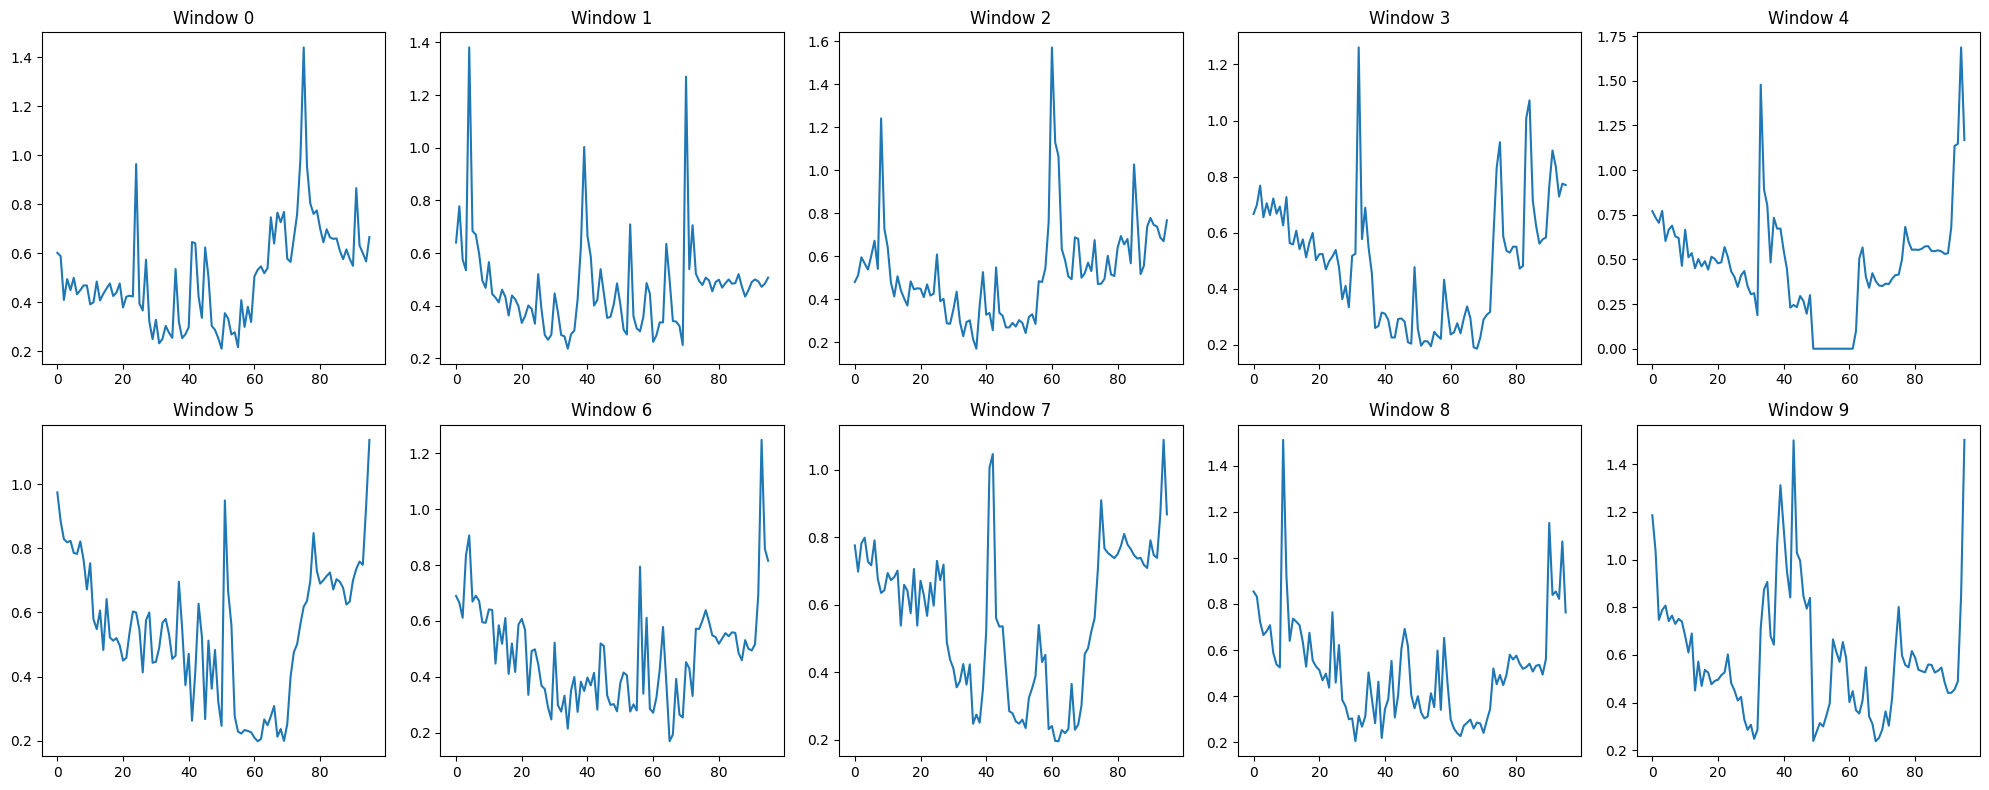

In [131]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, ax in enumerate(axs.flatten()):
    ax.plot(windowed_data[i])
    ax.set_title(f"Window {i}")
plt.tight_layout()
plt.show()

In [132]:
type(windowed_data)

numpy.ndarray

### Divide the data into train and test sets

`train_data_tensor[:-1]` and `train_data_tensor[1:]` are indexing operations on the train_data_tensor PyTorch tensor.

`train_data_tensor[:-1]` means all elements of train_data_tensor except for the last one. This is because in the context of the autoencoder model, we will be predicting the next time step based on the current time step, so the last element of train_data_tensor cannot be used as a predictor.

`train_data_tensor[1:]` means all elements of train_data_tensor except for the first one. This is because in the context of the autoencoder model, we will be training the model to predict the next time step given the current time step, so the first element of train_data_tensor cannot be used as a prediction target.

In summary, train_dataset contains tuples of input and target data, where the input data is `train_data_tensor[:-1]` and the target data is `train_data_tensor[1:]`.

In [156]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert the pandas dataframe to a numpy array
# data_np = user_1_clean.values

# Divide the data into training and test sets
train_data, test_data = train_test_split(windowed_data, test_size=0.2, shuffle=False)

# Reshape the data to have 2 dimensions
train_data_2d = train_data.reshape(train_data.shape[0], -1)
test_data_2d = test_data.reshape(test_data.shape[0], -1)

# Normalize the training set between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_norm = scaler.fit_transform(train_data_2d)

# Convert the numpy arrays to PyTorch tensors
train_data_tensor = torch.from_numpy(train_data_norm).float().view(-1, 1, window_size)   # `(batch_size, in_channels, sequence_length)`
test_data_tensor = torch.from_numpy(test_data_2d).float().view(-1, 1, window_size)       # `(batch_size, in_channels, sequence_length)`

# Prepare the data for the model using TensorDataset and DataLoader
train_dataset = TensorDataset(train_data_tensor[:-1], train_data_tensor[1:])
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(test_data_tensor[:-1], test_data_tensor[1:])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [157]:
# Check the shape
print("Number of batches in train dataloader:", len(train_dataloader))
print("Number of batches in test dataloader:", len(test_dataloader))

Number of batches in train dataloader: 9
Number of batches in test dataloader: 3


In [158]:
# Iterate through the dataloaders and check the shape of the batches
print("Train")
for i, batch in enumerate(train_dataloader):
    x, y = batch
    print("Shape of batch ", i+1, "in train dataloader:", x.shape, y.shape)

print("\nTest")
for i, batch in enumerate(test_dataloader):
    x, y = batch
    print("Shape of batch ", i+1, "in test dataloader:", x.shape, y.shape)

Train
Shape of batch  1 in train dataloader: torch.Size([32, 1, 96]) torch.Size([32, 1, 96])
Shape of batch  2 in train dataloader: torch.Size([32, 1, 96]) torch.Size([32, 1, 96])
Shape of batch  3 in train dataloader: torch.Size([32, 1, 96]) torch.Size([32, 1, 96])
Shape of batch  4 in train dataloader: torch.Size([32, 1, 96]) torch.Size([32, 1, 96])
Shape of batch  5 in train dataloader: torch.Size([32, 1, 96]) torch.Size([32, 1, 96])
Shape of batch  6 in train dataloader: torch.Size([32, 1, 96]) torch.Size([32, 1, 96])
Shape of batch  7 in train dataloader: torch.Size([32, 1, 96]) torch.Size([32, 1, 96])
Shape of batch  8 in train dataloader: torch.Size([32, 1, 96]) torch.Size([32, 1, 96])
Shape of batch  9 in train dataloader: torch.Size([6, 1, 96]) torch.Size([6, 1, 96])

Test
Shape of batch  1 in test dataloader: torch.Size([32, 1, 96]) torch.Size([32, 1, 96])
Shape of batch  2 in test dataloader: torch.Size([32, 1, 96]) torch.Size([32, 1, 96])
Shape of batch  3 in test dataloade

In the case of autoencoder, `x` usually represents the input data and `y` is the same as `x` as the model tries to reconstruct the input data as the output. 

The goal of an autoencoder is to learn a compressed representation of the input data in the encoding stage, and then to reconstruct the original data in the decoding stage.

In [143]:
for i, (x, y) in enumerate(train_dataloader):
    print(f"Batch {i}:")
    print(f"x = {x}")
    print(f"y = {y}")
    break

Batch 0:
x = tensor([[[-0.3100],
         [-0.4447],
         [-0.5392],
         ...,
         [-0.4259],
         [-0.4776],
         [-0.5325]],

        [[-0.2528],
         [-0.3350],
         [-0.5599],
         ...,
         [-0.1730],
         [-0.4245],
         [-0.2619]],

        [[-0.5111],
         [-0.5463],
         [-0.6571],
         ...,
         [-0.6881],
         [-0.7224],
         [-0.7118]],

        ...,

        [[-0.2823],
         [-0.2563],
         [-0.4869],
         ...,
         [ 0.0039],
         [ 0.1061],
         [-0.1002]],

        [[-0.2601],
         [-0.3399],
         [-0.5964],
         ...,
         [-0.2444],
         [-0.3864],
         [-0.2513]],

        [[-0.4539],
         [-0.4480],
         [-0.6620],
         ...,
         [-0.5252],
         [ 0.1619],
         [-0.0228]]])
y = tensor([[[-0.4945],
         [-0.4414],
         [-0.6292],
         ...,
         [-0.3623],
         [-0.4925],
         [-0.4798]],

        [[-0.2934

### 4. Define the model

This model takes in a tensor of shape `(batch_size, sequence_length, num_features)` as input and outputs a tensor of the same shape. 

We use `Conv1d` layers for the encoder and `ConvTranspose1d` layers for the decoder.

Note that the number of input channels for the first Conv1d layer is 1, because we are using a univariate time series as input. 

If you had a multivariate time series, you would set the number of input channels to the number of features in your data.

You can adjust the number of channels and the kernel sizes of the convolutional layers to increase or decrease the complexity of the model.

In [263]:
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder layers
        self.enc_conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.enc_conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Decoder layers
        self.dec_conv1 = nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=2, stride=2)
        self.dec_conv2 = nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=2, stride=2)
        self.dec_conv3 = nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=2, stride=2)
        
    def forward(self, x):
        # Encoder
        x = nn.functional.relu(self.enc_conv1(x))
        # print("Encoder Conv1 Output Shape: ", x.shape)
        x = self.pool(x)
        # print("Encoder MaxPool1 Output Shape: ", x.shape)
        x = nn.functional.relu(self.enc_conv2(x))
        # print("Encoder Conv2 Output Shape: ", x.shape)
        x = self.pool(x)
        # print("Encoder MaxPool2 Output Shape: ", x.shape)
        x = nn.functional.relu(self.enc_conv3(x))
        # print("Encoder Conv3 Output Shape: ", x.shape)
        x = self.pool(x)
        # print("Encoder MaxPool3 Output Shape: ", x.shape)

        # Decoder
        x = nn.functional.relu(self.dec_conv1(x))
        # print("Decoder ConvTranspose1 Output Shape: ", x.shape)
        x = nn.functional.relu(self.dec_conv2(x))
        # print("Decoder ConvTranspose2 Output Shape: ", x.shape)
        x = self.dec_conv3(x)
        # print("Decoder ConvTranspose3 Output Shape: ", x.shape)
        
        return x

In [182]:
# class ConvAutoencoder(nn.Module):
#     def __init__(self, input_size, latent_dim):
#         super(ConvAutoencoder, self).__init__()
        
#         # Encoder
#         self.enc_conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1)
#         self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
#         self.enc_conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1)
#         self.flatten = nn.Flatten()
#         self.enc_linear = nn.Linear(in_features=1440, out_features=latent_dim)
        
#         # Decoder
#         self.dec_linear = nn.Linear(in_features=latent_dim, out_features=1440)
#         self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 45))
#         self.dec_conv1 = nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=3, stride=1)
#         self.upsample = nn.Upsample(scale_factor=2)
#         self.dec_conv2 = nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=3, stride=1)

#     def forward(self, x):
#         # Encoder
#         x = nn.functional.relu(self.enc_conv1(x))
#         x = self.pool(x)
#         x = nn.functional.relu(self.enc_conv2(x))
#         x = self.flatten(x)
#         x = nn.functional.relu(self.enc_linear(x))
        
#         # Decoder
#         x = nn.functional.relu(self.dec_linear(x))
#         x = self.unflatten(x)
#         x = nn.functional.relu(self.dec_conv1(x))
#         x = self.upsample(x)
#         x = nn.functional.sigmoid(self.dec_conv2(x))
#         return x


The input shape for `Conv1d` should be `(batch_size, num_features, sequence_length)`. 

In our case, the batch size is determined by the batch_size argument in the `DataLoader`, the number of features is `1`, and the sequence length is the window size which is `96`. 

So, the shape of each input should be `(batch_size, 1, 96)`.

---

If we use `Conv2d` instead of `Conv1d`, the input shape should be `(batch_size, 1, window_size, 1)` instead of `(batch_size, window_size, 1)`.

This is because `Conv2d` expects a 4D tensor where the second dimension represents the number of channels. 

In our case, we only have one channel, so we set this dimension to `1`. The fourth dimension is set to 1 because we only have one feature.

---

If you want to use `Conv1d`, then the shape of the input tensor should be `(batch_size, in_channels, sequence_length)`, where `in_channels` is 1 in your case since you have a single feature. 

So for your specific case, the shape of the input tensor should be `(batch_size, 1, window_size)`, where `window_size` is 96.

However, if you decide to use `Conv2d`, then the shape of the input tensor should be `(batch_size, in_channels, height, width)`. 

Since you only have one feature, the `in_channels` would still be 1. 

You can choose the `height` and `width` of the input tensor based on the window size and how you want to shape the data for the convolutional layers. 

For example, you could set `height=1` and `width=window_size`, or you could set `height=window_size` and `width=1`

### Define loss and optimization functions

In [264]:
import torch.optim as optim

model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

model

ConvAutoencoder(
  (enc_conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (enc_conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (enc_conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec_conv1): ConvTranspose1d(64, 32, kernel_size=(2,), stride=(2,))
  (dec_conv2): ConvTranspose1d(32, 16, kernel_size=(2,), stride=(2,))
  (dec_conv3): ConvTranspose1d(16, 1, kernel_size=(2,), stride=(2,))
)

In [265]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

    48
    16
  1536
    32
  6144
    64
  4096
    32
  1024
    16
    32
     1
______
 13041


In [234]:
# for seq, y_train in train_data:
#     print(seq)
#     print(y_train)
#     break

### Train the model

`Conv1d` require the input shape `(batch_size, in_channels, sequence_length)`

We have to change from `(32, 96, 1)` to `(32, 1 ,96)` by using `permute`

`(batch_size, sequence_length, in_channels)`->`(batch_size, in_channels, sequence_length)`

In [235]:
# # Iterate through the dataloaders and check the shape of the batches
# print("Train")
# for i, batch in enumerate(train_dataloader):
#     x, y = batch
    
#     # Permute the dimensions of the tensor
#     x = x.permute(0, 2, 1)
    
#     print("Shape of batch ", i+1, "in train dataloader:", x.shape, y.shape)

# print("\nTest")
# for i, batch in enumerate(test_dataloader):
#     x, y = batch
    
#     # Permute the dimensions of the tensor
#     x = x.permute(0, 2, 1)
    
#     print("Shape of batch ", i+1, "in test dataloader:", x.shape, y.shape)

In [266]:
# Iterate through the dataloaders and check the shape of the batches
print("Train")
for i, batch in enumerate(train_dataloader):
    x, y = batch
    print("Shape of batch ", i+1, "in train dataloader:", x.shape, y.shape)

print("\nTest")
for i, batch in enumerate(test_dataloader):
    x, y = batch
    print("Shape of batch ", i+1, "in test dataloader:", x.shape, y.shape)

Train
Shape of batch  1 in train dataloader: torch.Size([32, 1, 96]) torch.Size([32, 1, 96])
Shape of batch  2 in train dataloader: torch.Size([32, 1, 96]) torch.Size([32, 1, 96])
Shape of batch  3 in train dataloader: torch.Size([32, 1, 96]) torch.Size([32, 1, 96])
Shape of batch  4 in train dataloader: torch.Size([32, 1, 96]) torch.Size([32, 1, 96])
Shape of batch  5 in train dataloader: torch.Size([32, 1, 96]) torch.Size([32, 1, 96])
Shape of batch  6 in train dataloader: torch.Size([32, 1, 96]) torch.Size([32, 1, 96])
Shape of batch  7 in train dataloader: torch.Size([32, 1, 96]) torch.Size([32, 1, 96])
Shape of batch  8 in train dataloader: torch.Size([32, 1, 96]) torch.Size([32, 1, 96])
Shape of batch  9 in train dataloader: torch.Size([6, 1, 96]) torch.Size([6, 1, 96])

Test
Shape of batch  1 in test dataloader: torch.Size([32, 1, 96]) torch.Size([32, 1, 96])
Shape of batch  2 in test dataloader: torch.Size([32, 1, 96]) torch.Size([32, 1, 96])
Shape of batch  3 in test dataloade

In [267]:
epochs = 1000

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_dataloader:
        
        #seq & y_train to device
        seq = seq.to(device)
        y_train = y_train.to(device)
        
        # reset the parameters
        optimizer.zero_grad()
        
        # apply the model
        y_pred = model(seq)                                  # 1. model

        # update parameters
        loss = criterion(y_pred, y_train.transpose(1, 2))    # 2. loss ,This should give you a tensor of shape `[batch_size, 1, seq_length]`
        loss.backward()
        optimizer.step()

    # print loss after each epoch
    if epoch % 100 == 0:
        print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 1.09509277
Epoch: 101 Loss: 0.75941247
Epoch: 201 Loss: 0.52912098
Epoch: 301 Loss: 0.38283888
Epoch: 401 Loss: 0.28554744
Epoch: 501 Loss: 0.21381681
Epoch: 601 Loss: 0.20030816
Epoch: 701 Loss: 0.18808396
Epoch: 801 Loss: 0.13451016
Epoch: 901 Loss: 0.11383428

Duration: 12 seconds


In [268]:
for seq, y_train in train_dataloader:
    print(seq.shape)
    print(y_train.shape)
    break

torch.Size([32, 1, 96])
torch.Size([32, 1, 96])


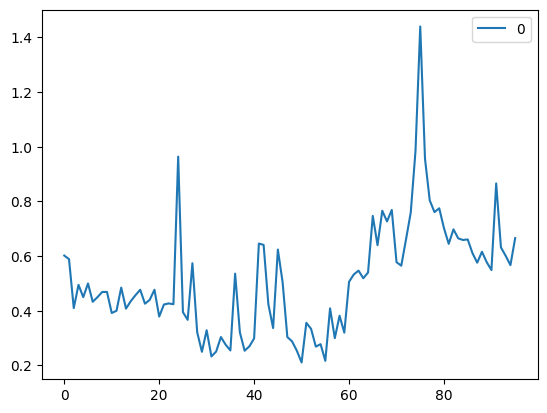

In [269]:
pd.DataFrame(windowed_data[0]).plot();

torch.Size([1, 1, 96])
(96,)
torch.Size([1, 1, 96])
(96,)
torch.Size([1, 1, 96])
(96,)
torch.Size([1, 1, 96])
(96,)
torch.Size([1, 1, 96])
(96,)
torch.Size([1, 1, 96])
(96,)
torch.Size([1, 1, 96])
(96,)
torch.Size([1, 1, 96])
(96,)
torch.Size([1, 1, 96])
(96,)
torch.Size([1, 1, 96])
(96,)


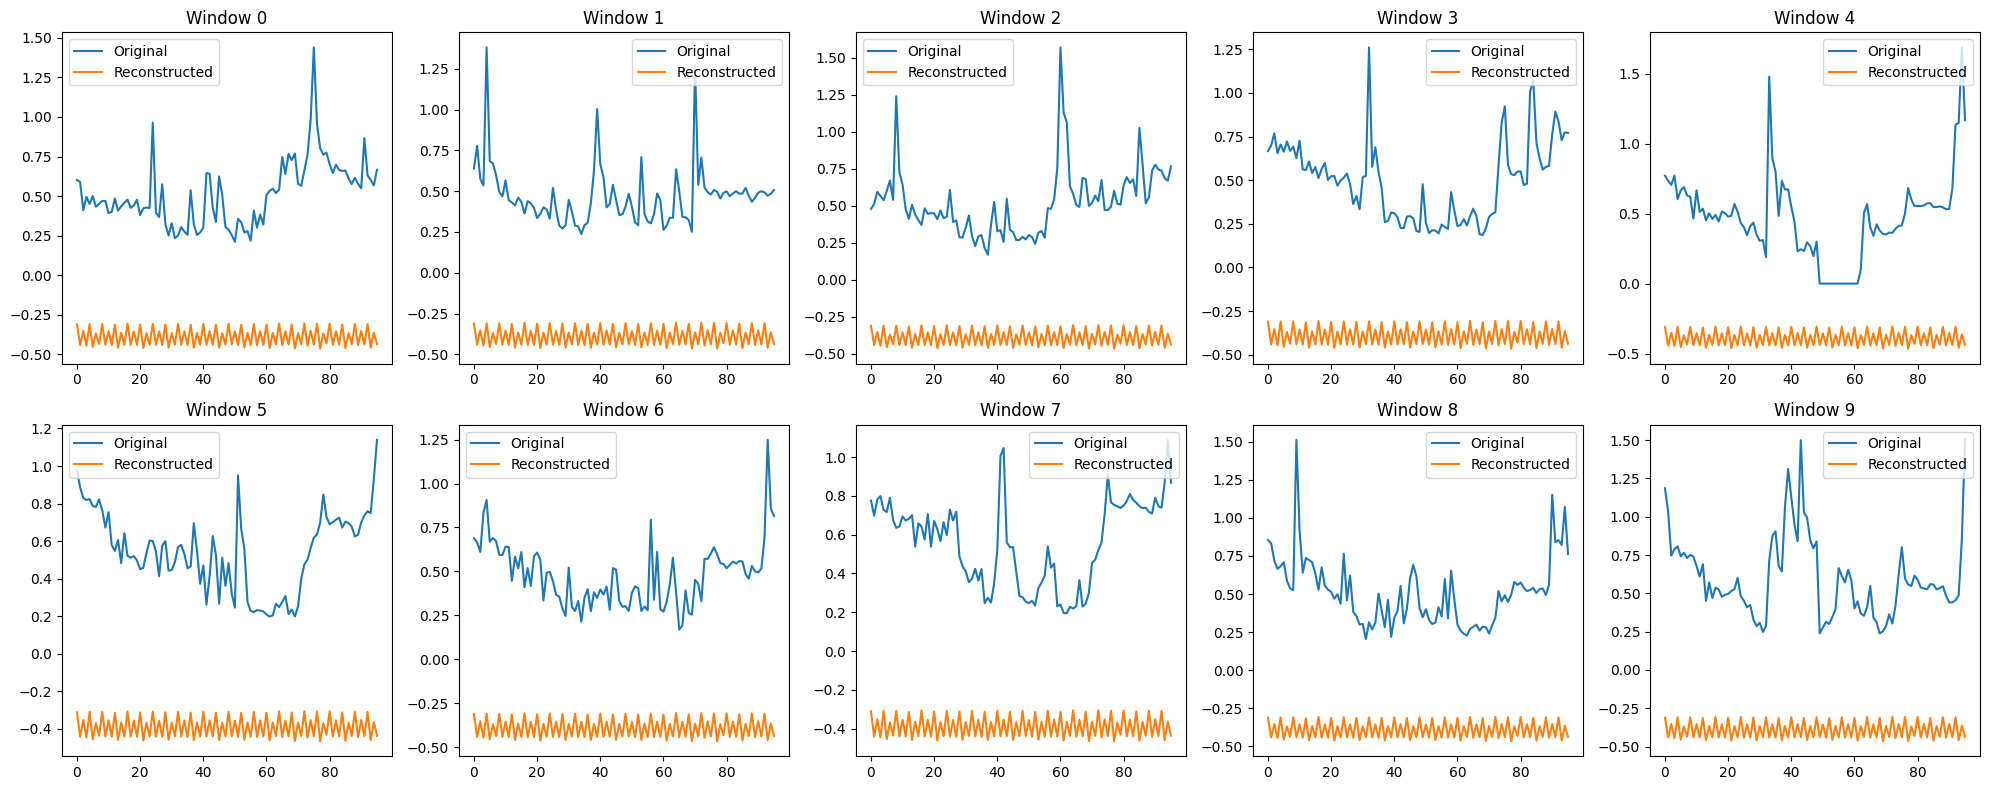

In [271]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

with torch.no_grad():
    for i, ax in enumerate(axs.flatten()):
        # convert windowed_data to PyTorch tensor and reshape to [1, 1, seq_length]
        x = torch.tensor(windowed_data[0]).unsqueeze(0).permute(0, 2, 1).to(device)   # shape: [1, 1, 96]
        print(x.shape)
        # get the reconstruction from the model
        y_pred = model(x.float()).squeeze().detach().cpu().numpy()
        
        # plot the original and reconstructed signal
        ax.plot(windowed_data[i])
        ax.plot(y_pred)
        print(y_pred.shape)
        ax.set_title(f"Window {i}")
        ax.legend(['Original', 'Reconstructed'])
        # break
plt.tight_layout()
plt.show()

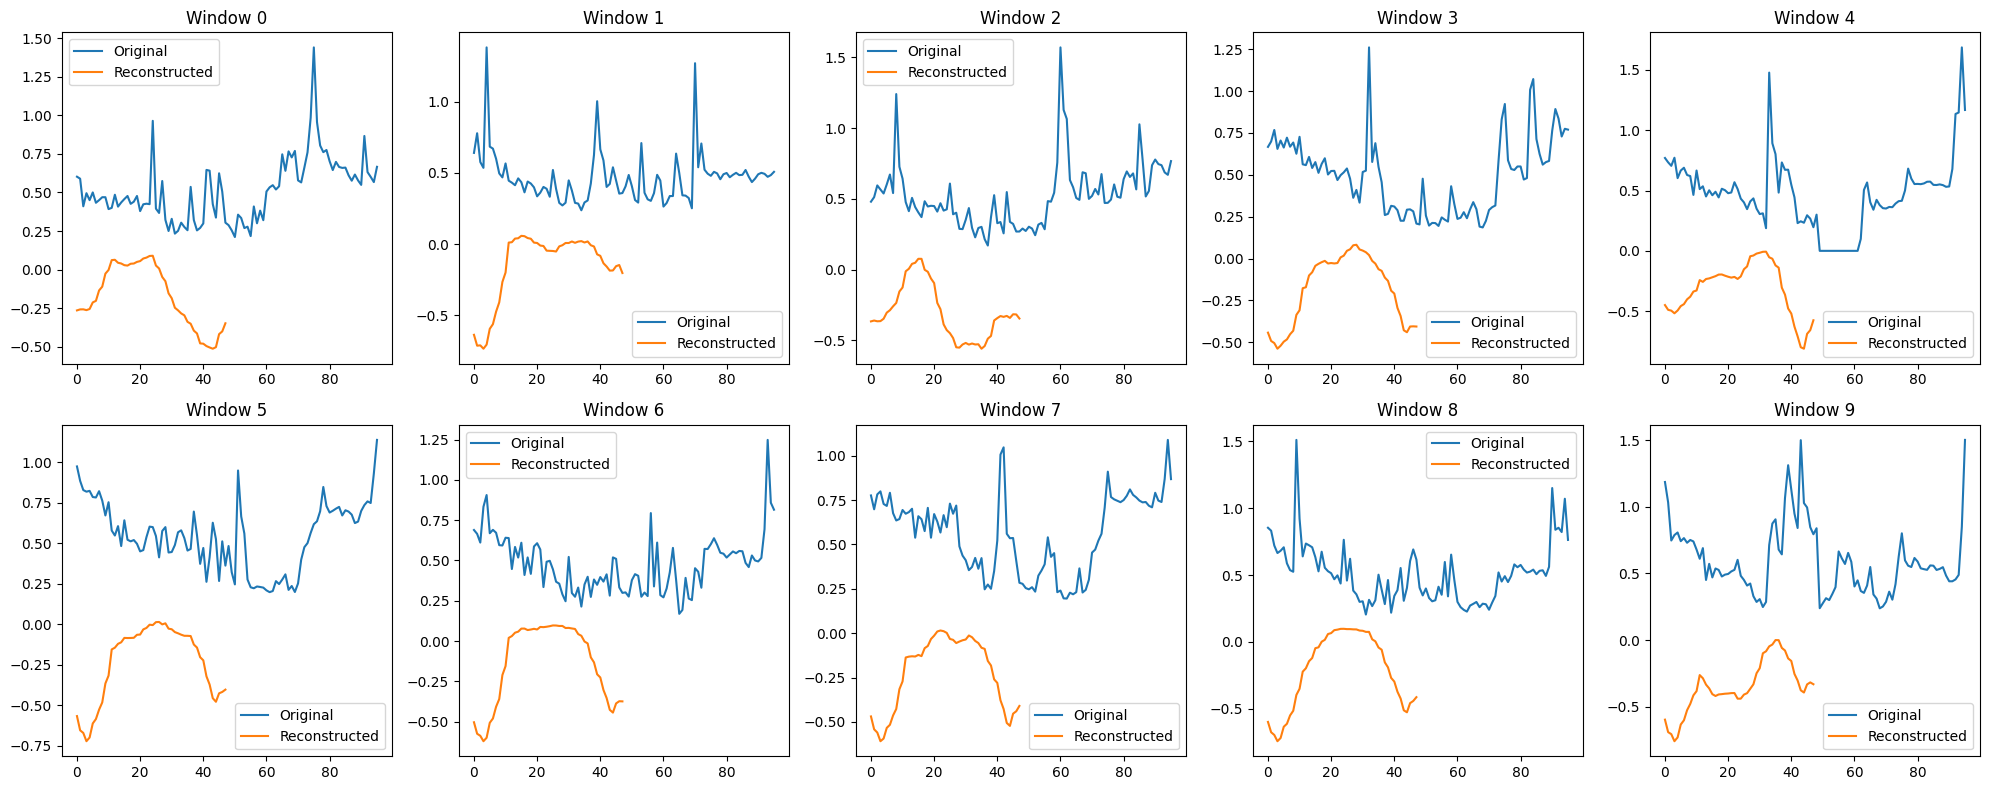

In [248]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

with torch.no_grad():
    for i, ax in enumerate(axs.flatten()):
        # convert windowed_data to PyTorch tensor and reshape to [1, 1, seq_length]
        x = torch.tensor(windowed_data[i]).unsqueeze(0).unsqueeze(0).to(device)   # shape: [1, 1, 96, 1]
        x = x.squeeze(-1)  # shape: [1, 1, 96]
        
        # get the reconstruction from the model
        y_pred = model(x.float()).squeeze().detach().cpu().numpy()
        y_pred = y_pred.reshape(-1)  # reshape y_pred to have shape (sequence_length,)
        
        # plot the original and reconstructed signal
        ax.plot(windowed_data[i])
        ax.plot(y_pred)
        
        ax.set_title(f"Window {i}")
        ax.legend(['Original', 'Reconstructed'])

plt.tight_layout()
plt.show()

### Test

In [249]:
import torch
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder layers
        self.enc_conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.enc_conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Decoder layers
        self.dec_conv1 = nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=2, stride=2)
        self.dec_conv2 = nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=2, stride=2)
        self.dec_conv3 = nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        x = nn.functional.relu(self.enc_conv1(x))
        print("Encoder Conv1 Output Shape: ", x.shape)
        x = self.pool(x)
        print("Encoder MaxPool1 Output Shape: ", x.shape)
        x = nn.functional.relu(self.enc_conv2(x))
        print("Encoder Conv2 Output Shape: ", x.shape)
        x = self.pool(x)
        print("Encoder MaxPool2 Output Shape: ", x.shape)
        x = nn.functional.relu(self.enc_conv3(x))
        print("Encoder Conv3 Output Shape: ", x.shape)
        x = self.pool(x)
        print("Encoder MaxPool3 Output Shape: ", x.shape)

        # Decoder
        x = nn.functional.relu(self.dec_conv1(x))
        print("Decoder ConvTranspose1 Output Shape: ", x.shape)
        x = nn.functional.relu(self.dec_conv2(x))
        print("Decoder ConvTranspose2 Output Shape: ", x.shape)
        x = self.dec_conv3(x)
        print("Decoder ConvTranspose3 Output Shape: ", x.shape)

        return x


In [257]:
model = ConvAutoencoder()

# Create a dummy input
x = torch.randn(1, 1, 96)

# Call the model with the input
y = model(x)

# Check the output shape
print("Final Output Shape: ", y.shape)

Encoder Conv1 Output Shape:  torch.Size([1, 16, 96])
Encoder MaxPool1 Output Shape:  torch.Size([1, 16, 48])
Encoder Conv2 Output Shape:  torch.Size([1, 32, 48])
Encoder MaxPool2 Output Shape:  torch.Size([1, 32, 24])
Encoder Conv3 Output Shape:  torch.Size([1, 64, 24])
Encoder MaxPool3 Output Shape:  torch.Size([1, 64, 12])
Decoder ConvTranspose1 Output Shape:  torch.Size([1, 32, 24])
Decoder ConvTranspose2 Output Shape:  torch.Size([1, 16, 48])
Decoder ConvTranspose3 Output Shape:  torch.Size([1, 1, 47])
Final Output Shape:  torch.Size([1, 1, 47])


In [273]:
# USE THIS FOR CHECK THE SHAPE !!!!!

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder layers
        self.enc_conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.enc_conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Decoder layers
        self.dec_conv1 = nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=2, stride=2)
        self.dec_conv2 = nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=2, stride=2)
        self.dec_conv3 = nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=2, stride=2)
        
    def forward(self, x):
        # Encoder
        x = nn.functional.relu(self.enc_conv1(x))
        print("Encoder Conv1 Output Shape: ", x.shape)
        x = self.pool(x)
        print("Encoder MaxPool1 Output Shape: ", x.shape)
        x = nn.functional.relu(self.enc_conv2(x))
        print("Encoder Conv2 Output Shape: ", x.shape)
        x = self.pool(x)
        print("Encoder MaxPool2 Output Shape: ", x.shape)
        x = nn.functional.relu(self.enc_conv3(x))
        print("Encoder Conv3 Output Shape: ", x.shape)
        x = self.pool(x)
        print("Encoder MaxPool3 Output Shape: ", x.shape)

        # Decoder
        x = nn.functional.relu(self.dec_conv1(x))
        print("Decoder ConvTranspose1 Output Shape: ", x.shape)
        x = nn.functional.relu(self.dec_conv2(x))
        print("Decoder ConvTranspose2 Output Shape: ", x.shape)
        x = self.dec_conv3(x)
        print("Decoder ConvTranspose3 Output Shape: ", x.shape)
        
        return x

model = ConvAutoencoder()

# Create a dummy input
x = torch.randn(1, 1, 96)

# Call the model with the input
y = model(x)

# Check the output shape
print("Final Output Shape: ", y.shape)

Encoder Conv1 Output Shape:  torch.Size([1, 16, 96])
Encoder MaxPool1 Output Shape:  torch.Size([1, 16, 48])
Encoder Conv2 Output Shape:  torch.Size([1, 32, 48])
Encoder MaxPool2 Output Shape:  torch.Size([1, 32, 24])
Encoder Conv3 Output Shape:  torch.Size([1, 64, 24])
Encoder MaxPool3 Output Shape:  torch.Size([1, 64, 12])
Decoder ConvTranspose1 Output Shape:  torch.Size([1, 32, 24])
Decoder ConvTranspose2 Output Shape:  torch.Size([1, 16, 48])
Decoder ConvTranspose3 Output Shape:  torch.Size([1, 1, 96])
Final Output Shape:  torch.Size([1, 1, 96])


In [172]:
# epochs = 500
# train_losses = []
# valid_losses = []

# for epoch in range(epochs):
    
#     # train the model
#     train_loss = 0.0
#     model.train()
#     for batch in train_dataloader:
#         inputs, targets = batch
#         inputs = inputs.to(device)
#         targets = targets.to(device)
        
#         optimizer.zero_grad()
        
#         outputs = model(inputs)
#         loss = criterion(outputs, targets.transpose(1, 2))
#         loss.backward()
#         optimizer.step()
        
#         train_loss += loss.item() * inputs.size(0)
        
#     train_loss /= len(train_dataset)
#     train_losses.append(train_loss)
    
#     # evaluate the model on validation set
#     valid_loss = 0.0
#     model.eval()
#     with torch.no_grad():
#         for batch in valid_dataloader:
#             inputs, targets = batch
#             inputs = inputs.to(device)
#             targets = targets.to(device)
            
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
            
#             valid_loss += loss.item() * inputs.size(0)
        
#     valid_loss /= len(valid_dataset)
#     valid_losses.append(valid_loss)
    
#     # print the losses
#     print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

# # plot the losses
# import matplotlib.pyplot as plt
# plt.plot(train_losses, label='Train Loss')
# plt.plot(valid_losses, label='Valid Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


In [62]:
# epochs = 50
# # val_old_loss = float("Inf")
# train_losses = []
# train_accs   = []
# val_losses   = []
# val_accs     = []
# # filepath = '../models/best_mnist.pt'

# import time
# start_time_total = time.time()

# #for epochs
# for epoch in range(epochs):
    
# #     #for train loader
# #     total_corr = 0
    
#     # extract the sequence & label from the training data
#     for seq, y_train in train_data:
        
#         start_time_1 = time.time()
        
#         #seq & y_train to device
#         seq = seq.to(device)
#         y_train = y_train.to(device)
        
#         # reset the parameters and hidden states
#         optimizer.zero_grad()
#         model.hidden = (torch.zeros(1,1,model.hidden_size).to(device),
#                         torch.zeros(1,1,model.hidden_size).to(device))
        
#         # apply the model
#         y_pred = model(seq)      # 1. model

#         # update parameters
#         loss = criterion(y_pred, y_train)    # 2. loss
#         loss.backward()
#         optimizer.step()
        
# #         #print the loss and acc if epoch / 1
# #         train_acc = (total_corr * 100) / (batch_size * (b + 1))
# #         train_accs.append(train_acc)
        
#         #total time
#         total_time = time.time() - start_time_1

#     # OPTIONAL print statement
#     # print(f'{i+1} of {epochs} epochs completed')
#     if epoch % 10 == 0:
#         print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
#         # print(f"Epoch: {e} - Batch: {b} - Train Loss: {train_loss:.2f} - Train Acc: {train_acc:.2f} - Total Time: {total_time:.2f}s")
        
#     # with torch.no_grad():
#     #     val_corr = 0 
#     #     for val_image, val_label in val_loader:
#     #         val_image = val_image.to(device)
#     #         val_label = val_label.to(device)
#     #         val_yhat = model(val_image)
#     #         val_loss = J_fn(val_yhat, val_label)
#     #         val_predicted = torch.max(val_yhat, 1)[1]
#     #         val_corr += (val_predicted == val_label).sum()
#     #         if val_loss < val_old_loss:
#     #             torch.save(model.state_dict(), filepath)
#     #     val_acc = (val_corr * 100) / len(val_set)
#     # val_accs.append(val_acc)
#     # val_losses.append(val_loss)
#     # # here you MUST SAVE THE BEST MODEL whenever val_loss < val_old_loss
#     # ##even if it takes time, you want to do this in your thesis....
        
# print(f'\nDuration: {time.time() - start_time_total:.0f} seconds')

## 5. Evaluate the model using the test set

In [65]:
len(test_set)

7008

In [71]:
future = 96
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:]).to(device)
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size).to(device),
                        torch.zeros(1,1,model.hidden_size).to(device))
        preds.append(model(seq).item())
        
preds[window_size:][:5]

[-0.6371443271636963,
 -0.6486324667930603,
 -0.6592532396316528,
 -0.6689152717590332,
 -0.6776772737503052]

### Inverse transform the predicted values

Rescale the predicted values up to the original test set range.

In [70]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions[:5]

array([[0.68652293],
       [0.66478737],
       [0.64469287],
       [0.62641231],
       [0.6098346 ]])

### Plot the result

Plot the true_predictions values together with the original data. Remember to create a range of datetime values for the predicted data.

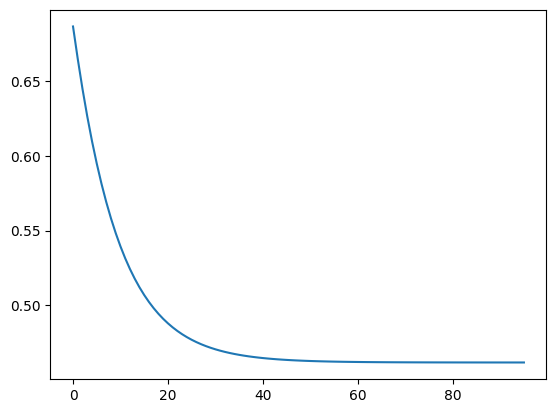

In [73]:
# plt.figure(figsize=(12,4))
# plt.title('Industrial Production Index for Electricity and Gas Utilities')
# plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
# plt.grid(True)
# plt.autoscale(axis='x',tight=True)
# plt.plot(data['KWH'])
plt.plot(true_predictions)
plt.show()

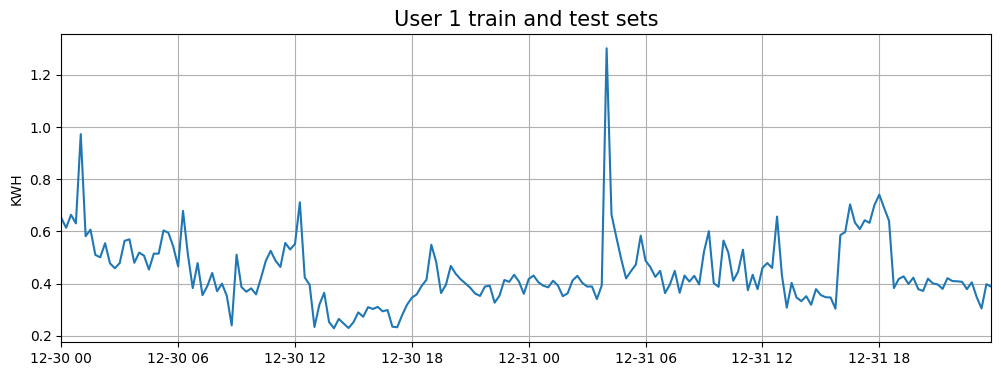

In [85]:
plt.figure(figsize=(12,4))
plt.title('User 1 train and test sets', size=15)
plt.ylabel('KWH')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(data['KWH']['2021-12-30':'2021-12-31'])
plt.show()

# Task

### VAE autocoder
* https://www.google.com/search?q=variational+autoencoder+based+anomaly+detection+using+reconstruction+probability+github&rlz=1C5CHFA_enTH999TH999&oq=Variational+Autoencoder+based+Anomaly+Detection+using+Reconstruction+Probability+&aqs=chrome.1.69i57j0i512j69i60.3070j0j7&sourceid=chrome&ie=UTF-8
* https://github.com/Michedev/VAE_anomaly_detection
* https://github.com/smile-yan/vae-anomaly-detection
* https://github.com/tarekmuallim/Anomaly-Detection-using-Variational-Autoencoders/blob/master/anomaly_detection_using_vae.py


### CNN
* https://github.com/khanmhmdi/Cifar-Image-Reconstruction-using-Autoencoder-Models/blob/main/Image_reconstruction.ipynb
* https://github.com/ebrahimpichka/conv-autoencoder (test on this now!!)